# MNIST CNN in PyTorch

Followed from [this tutorial](https://nextjournal.com/gkoehler/pytorch-mnist) and [this for visualizations](https://medium.com/dataseries/visualizing-the-feature-maps-and-filters-by-convolutional-neural-networks-e1462340518e). Used also for CP8321 A5.

In [8]:
!pip install torch torchvision tensorflow

  Using cached tensorflow-2.10.0-cp39-cp39-macosx_10_14_x86_64.whl (241.2 MB)
  Using cached absl_py-1.3.0-py3-none-any.whl (124 kB)
  Using cached Keras_Preprocessing-1.1.2-py2.py3-none-any.whl (42 kB)
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-22.10.26-py2.py3-none-any.whl (26 kB)
  Using cached tensorflow_estimator-2.10.0-py2.py3-none-any.whl (438 kB)
  Using cached tensorflow_io_gcs_filesystem-0.27.0-cp39-cp39-macosx_10_14_x86_64.whl (1.6 MB)
  Using cached keras-2.10.0-py2.py3-none-any.whl (1.7 MB)
  Using cached tensorboard-2.10.1-py3-none-any.whl (5.9 MB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
  Using cached termcolor-2.1.0-py3-none-any.whl (5.8 kB)
  Using cached libclang-14.0.6-py2.py3-none-macosx_10_9_x86_64.whl (13.2 MB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_auth_oauthlib-0.4.6-py2.py3-none-any.whl (18 kB)
  Using cache

In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

2022-11-13 18:13:01.217238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Hyperparameters

In [13]:
n_epochs = 3 # we can do more than 3 epochs.
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

### Data

In [15]:
train_dataset = torchvision.datasets.MNIST('./files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

test_dataset = torchvision.datasets.MNIST('./files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))


train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size_train, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size_test, 
                                          shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/train-labels-idx1-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-images-idx3-ubyte.gz to ./files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./files/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./files/MNIST/raw



In [16]:
print("Batches in Train Loader: {}".format(len(train_loader)))
print("Batches in Test Loader: {}".format(len(test_loader)))

print("Examples in Train Loader: {}".format(len(train_loader.sampler)))
print("Examples in Test Loader: {}".format(len(test_loader.sampler)))

Batches in Train Loader: 938
Batches in Test Loader: 10
Examples in Train Loader: 60000
Examples in Test Loader: 10000


In [17]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

The size of the data:

In [18]:
example_data.shape

torch.Size([1000, 1, 28, 28])

Let's see some cases; example images and their ground truth classes.

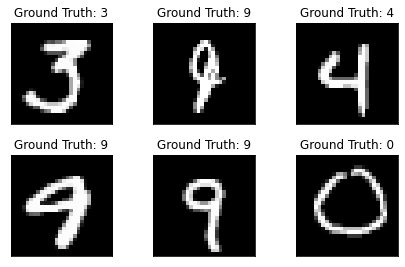

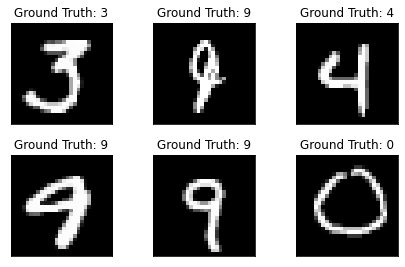

In [19]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

### Model Architecture

We have two conv layers and two fully-connected layers, with dropout between them.

In [20]:
from os import name
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50) # original: 320 x 50
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [21]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

To keep track of losses and the epoch count, for printing to the console.

In [22]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

### Initial Values

Let's inspect the size of the layers and their initial weight values.

In [23]:
for param in network.parameters():
    print(type(param.data), param.size())
print(network.conv1.weight.size())
print(network.conv2.weight.size())
print(network.fc1.weight.size())
print(network.fc2.weight.size())
print(network.conv1.weight)
print(network.fc2.weight)

<class 'torch.Tensor'> torch.Size([10, 1, 5, 5])
<class 'torch.Tensor'> torch.Size([10])
<class 'torch.Tensor'> torch.Size([20, 10, 5, 5])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([50, 320])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([10, 50])
<class 'torch.Tensor'> torch.Size([10])
torch.Size([10, 1, 5, 5])
torch.Size([20, 10, 5, 5])
torch.Size([50, 320])
torch.Size([10, 50])
Parameter containing:
tensor([[[[-0.1883,  0.1199, -0.0411,  0.1017,  0.0278],
          [-0.0245,  0.0555,  0.0099,  0.0730, -0.0779],
          [-0.0146, -0.0180,  0.0290, -0.0008,  0.1748],
          [ 0.0622, -0.0745, -0.1208, -0.0335, -0.0863],
          [-0.0641,  0.0096,  0.1192,  0.1087, -0.1955]]],


        [[[ 0.1240,  0.0559,  0.1897,  0.1320, -0.1822],
          [-0.1902, -0.0965,  0.1756, -0.0333,  0.0856],
          [-0.0929,  0.1962, -0.0846,  0.1500,  0.0024],
          [-0.1054,  0.1028, -0.1062,  0.0588, -0.0578],
          [-0.021

### Train

This function will print out some info at regular intervals (100 times per epoch).

It would be very messy to view the values stored in the large weight matrices every time, so I am printing out the norms of these matrices. We see that these change in the direction of a particular value, and do not get stuck at 0.

While training, we can also check the values of the feature maps, filters and weights to see how they progress during backpropagation.

In [24]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    optimizer.zero_grad()
    output = network(data)
    loss = F.nll_loss(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:

      c1 = float(torch.norm(network.conv1.weight.data))
      c2 = float(torch.norm(network.conv2.weight.data))
      f1 = float(torch.norm(network.fc1.weight.data))
      f2 = float(torch.norm(network.fc2.weight.data))

      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

      print('Norms- conv1: {:.3f}, conv2: {:.3f}, fc1: {:.3f}, fc2: {:.3f}'.format(c1, c2, f1, f2))

      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), './model.pth')
      torch.save(optimizer.state_dict(), './optimizer.pth')

### Test

After each epoch of training, we will test the network to see the predictions after that much training.

In [25]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [26]:
test() # How good is the model with the default parameters?
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/var/folders/78/px73zxmj5ks9051sxkyvbfd00000gn/T/ipykernel_23372/2026870952.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/Users/lorybuttazzoni/opt/anaconda3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 2.3096, Accuracy: 924/10000 (9%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.313179
Norms- conv1: 1.847, conv2: 2.584, fc1: 4.082, fc2: 1.849
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.300776
Norms- conv1: 1.845, conv2: 2.583, fc1: 4.082, fc2: 1.847
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.298872
Norms- conv1: 1.846, conv2: 2.584, fc1: 4.082, fc2: 1.848
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.276723
Norms- conv1: 1.847, conv2: 2.585, fc1: 4.083, fc2: 1.849
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.241102
Norms- conv1: 1.851, conv2: 2.588, fc1: 4.085, fc2: 1.853
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.248662
Norms- conv1: 1.856, conv2: 2.592, fc1: 4.088, fc2: 1.858
Train Epoch: 1 [3840/60000 (6%)]	Loss: 2.189547
Norms- conv1: 1.864, conv2: 2.598, fc1: 4.092, fc2: 1.866
Train Epoch: 1 [4480/60000 (7%)]	Loss: 2.146399
Norms- conv1: 1.872, conv2: 2.604, fc1: 4.096, fc2: 1.875
Train Epoch: 1 [5120/60000 (9%)]	Loss: 2.107701
Norms- conv1: 1.885, conv2: 2.614, fc1: 4.103, fc2: 

Train Epoch: 1 [48640/60000 (81%)]	Loss: 0.403204
Norms- conv1: 2.534, conv2: 3.176, fc1: 4.687, fc2: 2.635
Train Epoch: 1 [49280/60000 (82%)]	Loss: 0.388118
Norms- conv1: 2.537, conv2: 3.179, fc1: 4.692, fc2: 2.639
Train Epoch: 1 [49920/60000 (83%)]	Loss: 0.521023
Norms- conv1: 2.543, conv2: 3.185, fc1: 4.698, fc2: 2.646
Train Epoch: 1 [50560/60000 (84%)]	Loss: 0.437831
Norms- conv1: 2.547, conv2: 3.189, fc1: 4.704, fc2: 2.651
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.688478
Norms- conv1: 2.551, conv2: 3.193, fc1: 4.708, fc2: 2.656
Train Epoch: 1 [51840/60000 (86%)]	Loss: 0.506551
Norms- conv1: 2.556, conv2: 3.197, fc1: 4.714, fc2: 2.662
Train Epoch: 1 [52480/60000 (87%)]	Loss: 0.675337
Norms- conv1: 2.556, conv2: 3.198, fc1: 4.716, fc2: 2.663
Train Epoch: 1 [53120/60000 (88%)]	Loss: 0.539167
Norms- conv1: 2.554, conv2: 3.198, fc1: 4.719, fc2: 2.663
Train Epoch: 1 [53760/60000 (90%)]	Loss: 0.559808
Norms- conv1: 2.558, conv2: 3.201, fc1: 4.723, fc2: 2.667
Train Epoch: 1 [54400/60000 

Train Epoch: 2 [37120/60000 (62%)]	Loss: 0.488538
Norms- conv1: 2.740, conv2: 3.406, fc1: 4.995, fc2: 2.910
Train Epoch: 2 [37760/60000 (63%)]	Loss: 0.434376
Norms- conv1: 2.743, conv2: 3.410, fc1: 4.999, fc2: 2.914
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.277579
Norms- conv1: 2.744, conv2: 3.412, fc1: 5.002, fc2: 2.916
Train Epoch: 2 [39040/60000 (65%)]	Loss: 0.196538
Norms- conv1: 2.749, conv2: 3.417, fc1: 5.006, fc2: 2.922
Train Epoch: 2 [39680/60000 (66%)]	Loss: 0.427959
Norms- conv1: 2.753, conv2: 3.421, fc1: 5.010, fc2: 2.926
Train Epoch: 2 [40320/60000 (67%)]	Loss: 0.197449
Norms- conv1: 2.755, conv2: 3.423, fc1: 5.013, fc2: 2.929
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.490782
Norms- conv1: 2.756, conv2: 3.425, fc1: 5.017, fc2: 2.931
Train Epoch: 2 [41600/60000 (69%)]	Loss: 0.140071
Norms- conv1: 2.764, conv2: 3.432, fc1: 5.023, fc2: 2.939
Train Epoch: 2 [42240/60000 (70%)]	Loss: 0.341662
Norms- conv1: 2.767, conv2: 3.435, fc1: 5.027, fc2: 2.942
Train Epoch: 2 [42880/60000 

Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.416054
Norms- conv1: 2.869, conv2: 3.573, fc1: 5.223, fc2: 3.088
Train Epoch: 3 [26240/60000 (44%)]	Loss: 0.205225
Norms- conv1: 2.868, conv2: 3.572, fc1: 5.224, fc2: 3.088
Train Epoch: 3 [26880/60000 (45%)]	Loss: 0.205759
Norms- conv1: 2.868, conv2: 3.573, fc1: 5.226, fc2: 3.088
Train Epoch: 3 [27520/60000 (46%)]	Loss: 0.205646
Norms- conv1: 2.870, conv2: 3.575, fc1: 5.229, fc2: 3.091
Train Epoch: 3 [28160/60000 (47%)]	Loss: 0.319231
Norms- conv1: 2.872, conv2: 3.578, fc1: 5.232, fc2: 3.093
Train Epoch: 3 [28800/60000 (48%)]	Loss: 0.475816
Norms- conv1: 2.873, conv2: 3.580, fc1: 5.235, fc2: 3.095
Train Epoch: 3 [29440/60000 (49%)]	Loss: 0.170877
Norms- conv1: 2.872, conv2: 3.580, fc1: 5.237, fc2: 3.094
Train Epoch: 3 [30080/60000 (50%)]	Loss: 0.274327
Norms- conv1: 2.873, conv2: 3.582, fc1: 5.239, fc2: 3.096
Train Epoch: 3 [30720/60000 (51%)]	Loss: 0.240216
Norms- conv1: 2.874, conv2: 3.583, fc1: 5.242, fc2: 3.098
Train Epoch: 3 [31360/60000 

### Layer Info

In [27]:
model_weights = [] 
conv_layers = []
model_children = list(network.children())

linear_layers = [] 
model_linear_weights = []

# counter to keep count of the conv layers
counter = 0 
counter_linear = 0

# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Linear:
        counter_linear += 1
        model_linear_weights.append(model_children[i].weight)
        linear_layers.append(model_children[i])
print(f"Total convolutional layers: {counter}")
print(f"Total linear layers: {counter_linear}")

Total convolutional layers: 2
Total linear layers: 2


In [28]:
for i in range(len(model_children)):
  print(type(model_children[i]))

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.dropout.Dropout2d'>
<class 'torch.nn.modules.linear.Linear'>
<class 'torch.nn.modules.linear.Linear'>


In [29]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

CONV: Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([10, 1, 5, 5])
CONV: Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1)) ====> SHAPE: torch.Size([20, 10, 5, 5])


In [30]:
for weight, linear in zip(model_weights, linear_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"Linear: {linear} ====> SHAPE: {weight.shape}")

Linear: Linear(in_features=320, out_features=50, bias=True) ====> SHAPE: torch.Size([10, 1, 5, 5])
Linear: Linear(in_features=50, out_features=10, bias=True) ====> SHAPE: torch.Size([20, 10, 5, 5])


### After Training: The Model

Here are the weights of the linear layers. These are fully-connected, so there are many.

torch.Size([50, 320])
torch.Size([10, 50])


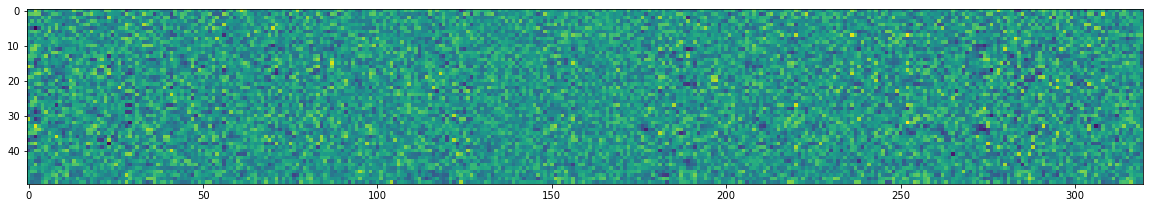

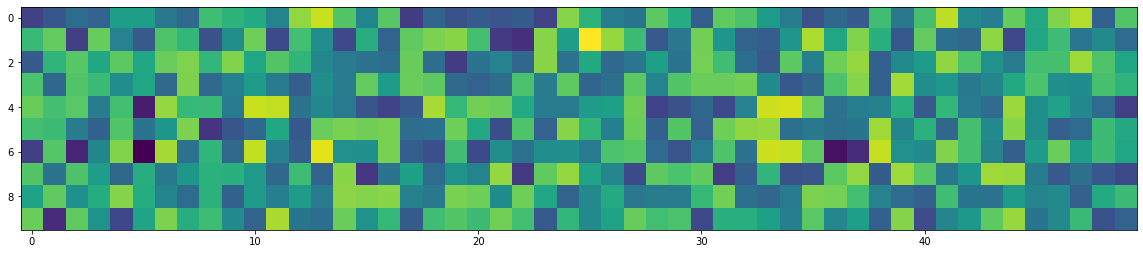

In [31]:
print(model_linear_weights[0].shape)
print(model_linear_weights[1].shape)
plt.figure(figsize=(20, 17))
plt.imshow(model_linear_weights[0].detach().numpy())
plt.figure(figsize=(20, 17))
plt.imshow(model_linear_weights[1].detach().numpy())

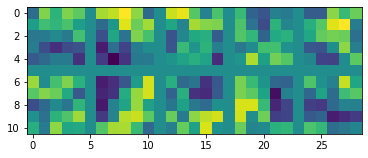

In [32]:
#plt.imshow(model_weights[0].detach().numpy()[0][0])
#plt.imshow(model_weights[0].detach().numpy().reshape(10, 5, 5).reshape(10, 25))
A = np.zeros((11, 29))

k = 0
for i in range(2):
  for j in range(5):
    A[5*i+i:5*(i+1)+i, 5*j+j:5*(j+1)+j] = model_weights[0].detach().numpy()[k][0]
    k += 1

#A[0:5, 0:5] = model_weights[0].detach().numpy()[0][0]
#A[0:5, 5:10] = model_weights[0].detach().numpy()[1][0]

plt.imshow(A)

Weights of the first conv layer.

[[-0.10355853  0.2432864   0.11843319  0.24272     0.19729221]
 [ 0.05266387  0.15611117  0.1295883   0.17150761  0.05215835]
 [-0.06967475 -0.05923887 -0.01322672 -0.05745829  0.16178523]
 [-0.04931245 -0.1894802  -0.26807317 -0.19473158 -0.17688298]
 [-0.15263142 -0.11027091 -0.0582195  -0.06042293 -0.26112628]]
[[ 0.28590596  0.31492397  0.38874787  0.25931653 -0.10861052]
 [-0.10853633  0.02916484  0.35199693  0.21647699  0.28266177]
 [-0.18803082  0.07784872 -0.08332305  0.24177739  0.16810784]
 [-0.31080025 -0.09511328 -0.21977767 -0.05276442  0.00078615]
 [-0.24125035 -0.37237847 -0.25420985 -0.06478219 -0.06232504]]
[[ 0.3248085   0.36487544  0.1870481  -0.03407615  0.1687656 ]
 [ 0.07626848 -0.03305111  0.2860814   0.24948095  0.23935612]
 [-0.17620572 -0.019214    0.08877688  0.10445114 -0.15155382]
 [-0.17155579  0.14113167  0.02324723  0.11941974 -0.04670707]
 [ 0.02134579  0.06645036  0.10802354  0.07240304 -0.27585062]]
[[ 0.14408714 -0.1256923  -0.17115054 -0.0365558  -0

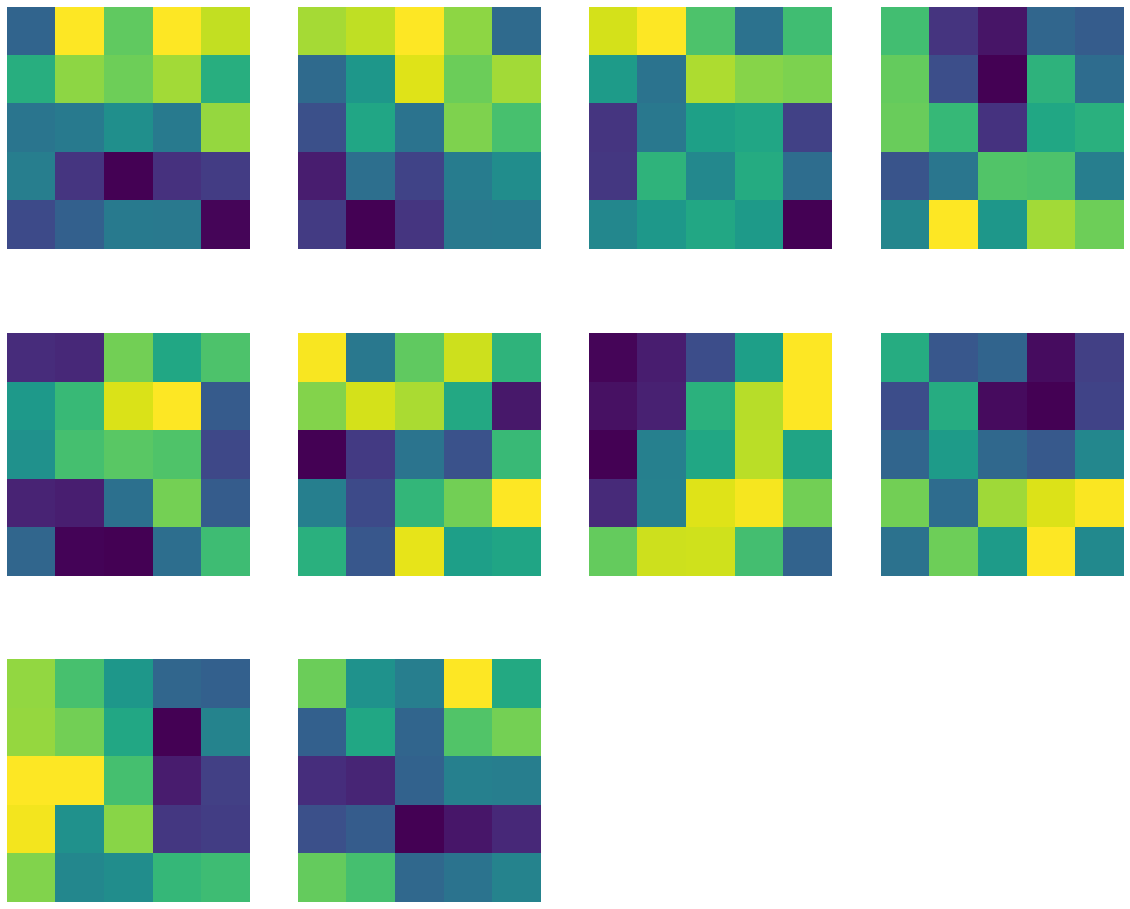

In [33]:
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(3, 4, i+1) # we have 5x5 filters and total of 10 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy())
    print(filter[0,:,:].detach().cpu().numpy())
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

Weights of the second conv layer.

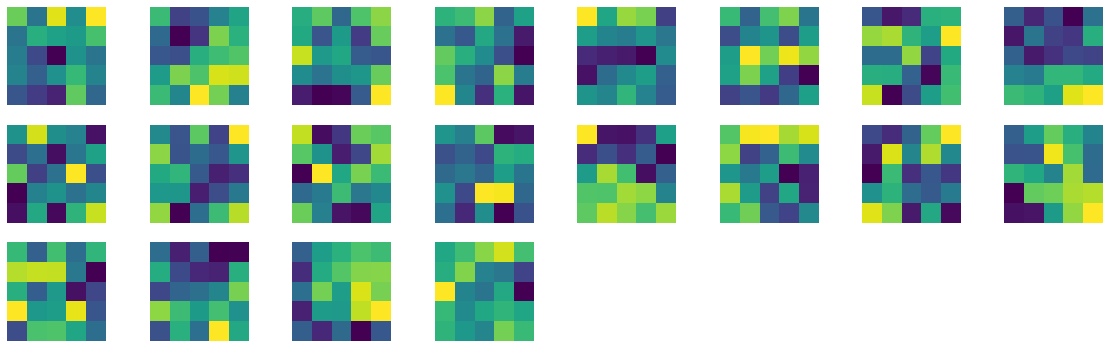

In [56]:
# visualize the second conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[1]):
    plt.subplot(8, 8, i+1) # (8, 8) because in conv0 we have 5x5 filters and total of 64 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy())
    #print(filter[0,:,:].detach().cpu().numpy())
    plt.axis('off')
    plt.savefig('filter2.png')
plt.show()

Feature Maps

In [35]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
network = network.to(device)

In [36]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

/var/folders/78/px73zxmj5ks9051sxkyvbfd00000gn/T/ipykernel_23372/2026870952.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


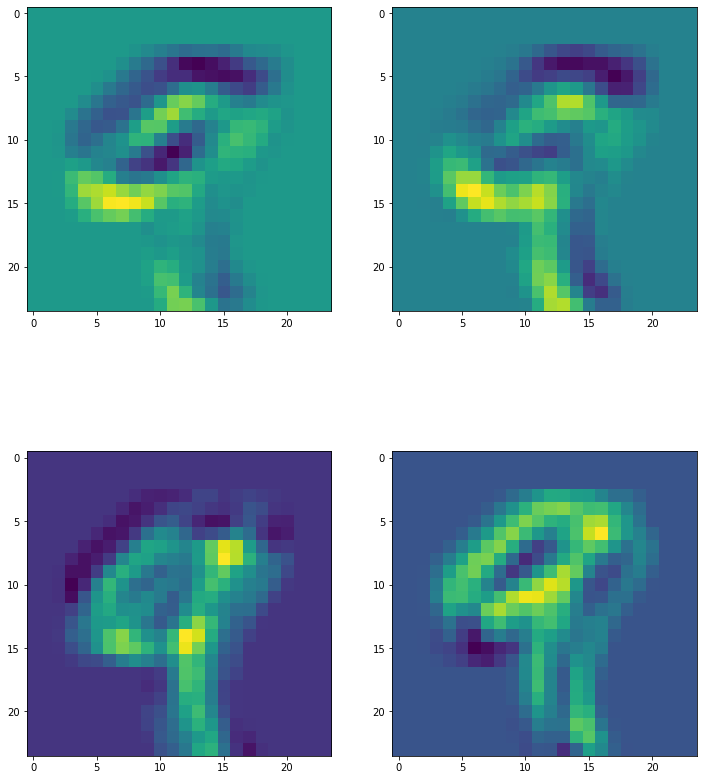

In [37]:
network.conv1.register_forward_hook(get_activation('conv1'))
data, _ = train_dataset[4]
data=data.to(device)
data.unsqueeze_(0)
output = network(data)

k=0
act = activation['conv1'].squeeze()
fig,ax = plt.subplots(2,2,figsize=(12, 15))

for i in range(act.size(0)//4):
        for j in range(act.size(0)//4):
           ax[i,j].imshow(act[k].detach().cpu().numpy())
           k+=1    
           plt.savefig('fm1.png') 

In [38]:
conv_layers

[Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))]

In [39]:
image, _ = train_dataset[4]

outputs = []
names = []

for layer in conv_layers[0:]:
    image = layer(image)
    outputs.append(image)
    names.append(str(layer))
print(len(outputs))

#print feature_maps

for feature_map in outputs:
    print(feature_map.shape)

2
torch.Size([10, 24, 24])
torch.Size([20, 20, 20])


In [40]:
processed = []
for feature_map in outputs:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    processed.append(gray_scale.data.cpu().numpy())
for fm in processed:
    print(fm.shape)

(24, 24)
(20, 20)


(24, 24)
(20, 20)


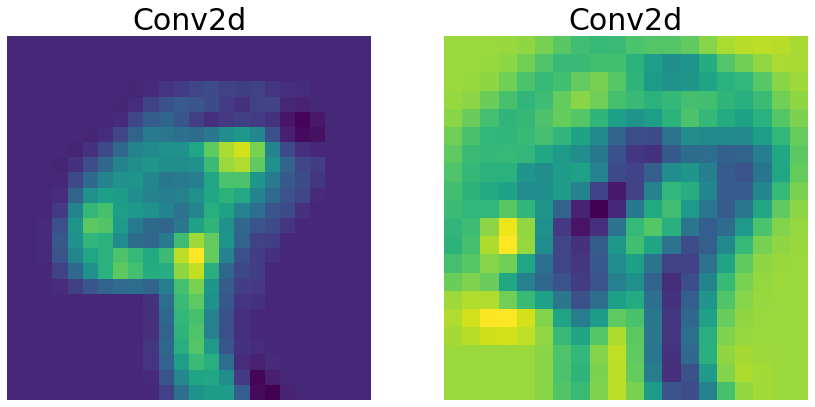

In [41]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(processed[i])
    print(processed[i].shape)
    a.axis("off")
    a.set_title(names[i].split('(')[0], fontsize=30)
plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')

/var/folders/78/px73zxmj5ks9051sxkyvbfd00000gn/T/ipykernel_23372/2026870952.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


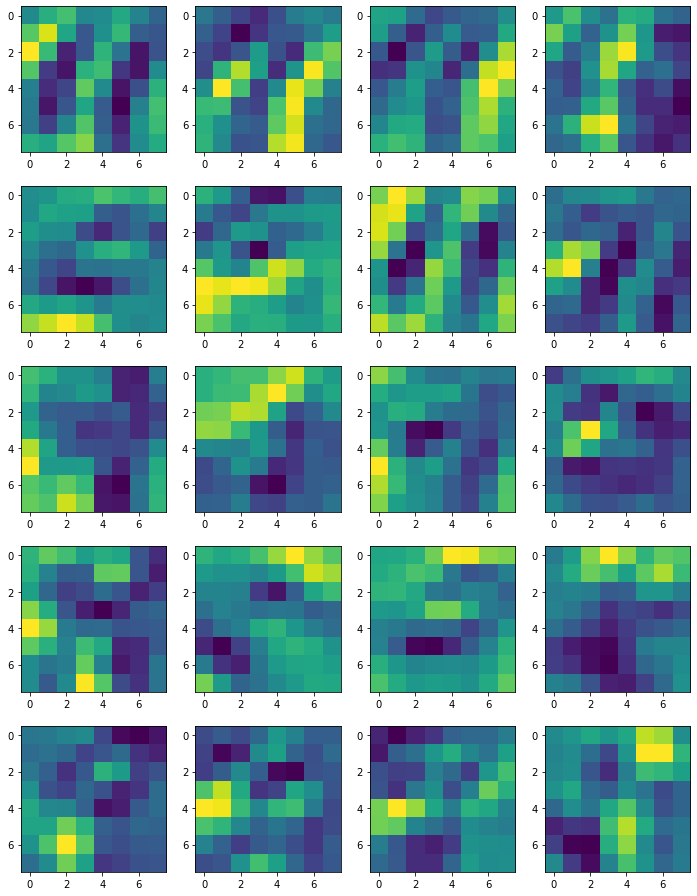

In [42]:
network.conv2.register_forward_hook(get_activation('conv2'))
data, _ = train_dataset[4]
data.unsqueeze_(0)
output = network(data)

k = 0
act = activation['conv2'].squeeze()
fig, axarr = plt.subplots(act.size(0)//4,4,figsize=(12, 16))

for i in range(act.size(0)//4):
        for j in range(4):
          axarr[i,j].imshow(act[k].detach().cpu().numpy())
          k+=1  
          plt.savefig('fm2.png')  

### Diagrams

#### Log-Likelihood versus Examples Seen

Let's plot the loss of the NN as it trains. The blue curve shows the loss on the training set. The red dots show the loss on the test set.

The training loss shows up as a blue curve whereas the test loss shows up as red dots since we evaluate the model on the training set 100 times per epoch, but only 1 time per epoch on the test set.

/var/folders/78/px73zxmj5ks9051sxkyvbfd00000gn/T/ipykernel_23372/2026870952.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Text(0, 0.5, 'negative log likelihood loss')

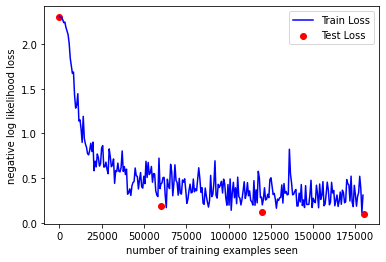

In [43]:
with torch.no_grad():
  output = network(example_data)

fig = plt.figure()
plt.plot(train_counter, train_losses, color='blue')
plt.scatter(test_counter, test_losses, color='red')
plt.legend(['Train Loss', 'Test Loss'], loc='upper right')
plt.xlabel('number of training examples seen')
plt.ylabel('negative log likelihood loss')

#### Some examples

Let us see how the model does on a few images.

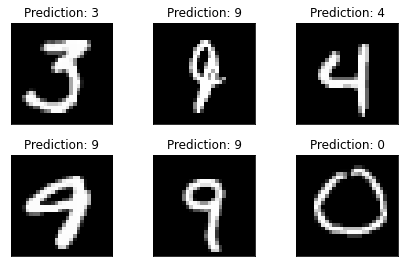

In [44]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Prediction: {}".format(
    output.data.max(1, keepdim=True)[1][i].item()))
  plt.xticks([])
  plt.yticks([])

#### Final weights

After some epochs of training, let's take a look at the weight matrices. These would also get stored into the results folder.

In [45]:
print(network.conv1.weight.size())
print(network.conv2.weight.size())
print(network.fc1.weight.size())
print(network.fc2.weight.size())
print(network.conv1.weight)
print(network.fc2.weight)

torch.Size([10, 1, 5, 5])
torch.Size([20, 10, 5, 5])
torch.Size([50, 320])
torch.Size([10, 50])
Parameter containing:
tensor([[[[-0.1036,  0.2433,  0.1184,  0.2427,  0.1973],
          [ 0.0527,  0.1561,  0.1296,  0.1715,  0.0522],
          [-0.0697, -0.0592, -0.0132, -0.0575,  0.1618],
          [-0.0493, -0.1895, -0.2681, -0.1947, -0.1769],
          [-0.1526, -0.1103, -0.0582, -0.0604, -0.2611]]],


        [[[ 0.2859,  0.3149,  0.3887,  0.2593, -0.1086],
          [-0.1085,  0.0292,  0.3520,  0.2165,  0.2827],
          [-0.1880,  0.0778, -0.0833,  0.2418,  0.1681],
          [-0.3108, -0.0951, -0.2198, -0.0528,  0.0008],
          [-0.2413, -0.3724, -0.2542, -0.0648, -0.0623]]],


        [[[ 0.3248,  0.3649,  0.1870, -0.0341,  0.1688],
          [ 0.0763, -0.0331,  0.2861,  0.2495,  0.2394],
          [-0.1762, -0.0192,  0.0888,  0.1045, -0.1516],
          [-0.1716,  0.1411,  0.0232,  0.1194, -0.0467],
          [ 0.0213,  0.0665,  0.1080,  0.0724, -0.2759]]],


        [[[ 0.1

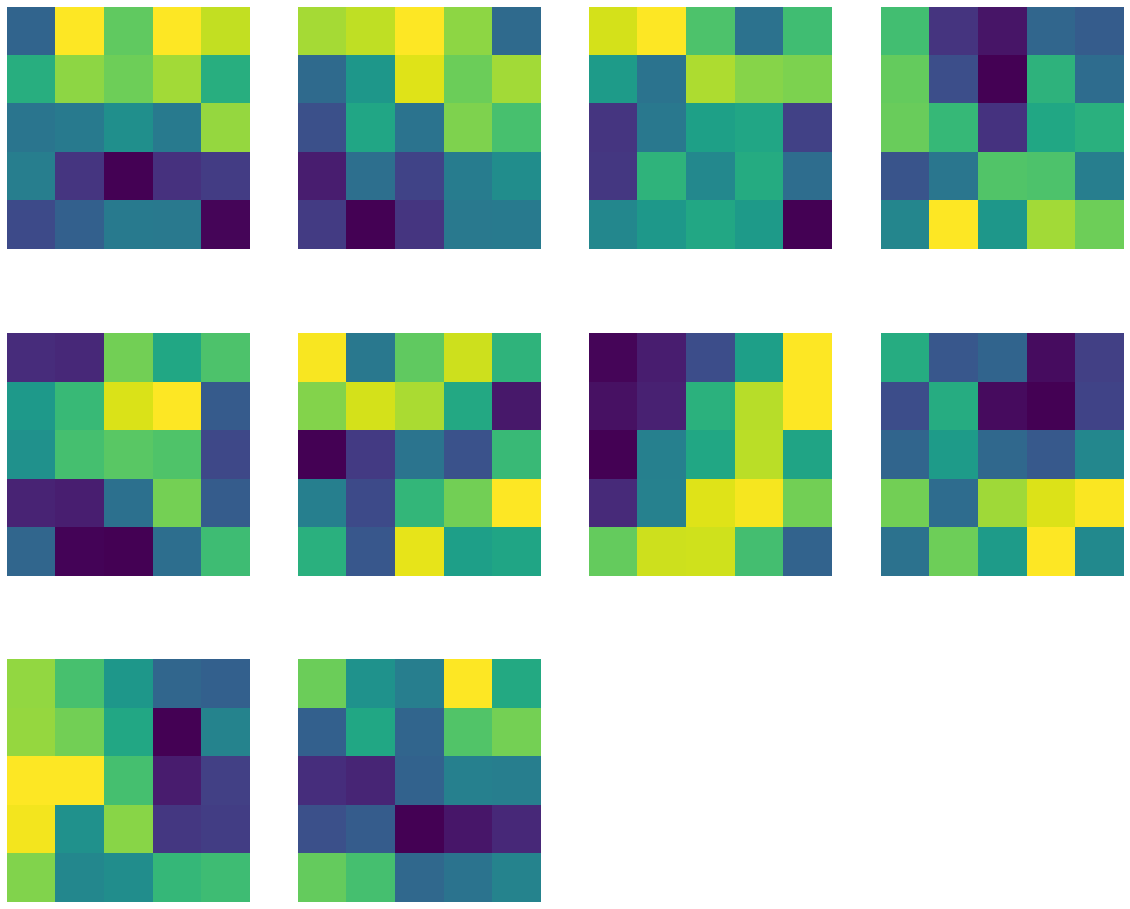

In [46]:
plt.figure(figsize=(20, 17))
for i in range(10):
    plt.subplot(3, 4, i+1)
    plt.imshow(network.conv1.weight.data[i][0])
    plt.axis('off')
    plt.savefig('filter1.png')
plt.show()

#### Norms

Let's take a look at those final norms. Notice that they seem to be virtually the same as those printed out during the end of the last training epoch.

In [47]:
print(
float(torch.norm(network.conv1.weight.data)),
float(torch.norm(network.conv2.weight.data)),
float(torch.norm(network.fc1.weight.data)),
float(torch.norm(network.fc2.weight.data))
)

2.9323325157165527 3.6658847332000732 5.358343601226807 3.180638313293457


In [48]:
for param in network.parameters():
    print(type(param.data), param.size())

<class 'torch.Tensor'> torch.Size([10, 1, 5, 5])
<class 'torch.Tensor'> torch.Size([10])
<class 'torch.Tensor'> torch.Size([20, 10, 5, 5])
<class 'torch.Tensor'> torch.Size([20])
<class 'torch.Tensor'> torch.Size([50, 320])
<class 'torch.Tensor'> torch.Size([50])
<class 'torch.Tensor'> torch.Size([10, 50])
<class 'torch.Tensor'> torch.Size([10])


In [49]:
for name, param in network.named_parameters():
  if param.requires_grad:
    print(name)

conv1.weight
conv1.bias
conv2.weight
conv2.bias
fc1.weight
fc1.bias
fc2.weight
fc2.bias


In [50]:
!pip install torchsummary

  Using cached torchsummary-1.5.1-py3-none-any.whl (2.8 kB)


In [51]:
import torchsummary
torchsummary.summary(network, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
            Conv2d-2             [-1, 20, 8, 8]           5,020
         Dropout2d-3             [-1, 20, 8, 8]               0
            Linear-4                   [-1, 50]          16,050
            Linear-5                   [-1, 10]             510
Total params: 21,840
Trainable params: 21,840
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.08
Estimated Total Size (MB): 0.15
----------------------------------------------------------------


/var/folders/78/px73zxmj5ks9051sxkyvbfd00000gn/T/ipykernel_23372/2026870952.py:18: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
